# ME 571 Project
## Jenny Fothergill
#### due May 6, 2020

For the final project I will be taking the Julia set CUDA code from HW5 and modifying it to additionally plot the Mandelbrot set, then adding a python wrapper which will sweep out a curve of the Mandelbrot set and plot the corresponding Julia set.

#### Table of contents
<a id='toc'></a>

- [Julia set cuda code](#jcuda)

- [Mandelbrot set cuda code](#mcuda)

- [Python wrapper](#py)

- [Final gif](#gif)

In [69]:
%%file fractal.cu
#include <stdio.h>
#include <stdlib.h>
#include <cuComplex.h>
#include <math.h> 

#define IDX(i,j,cols,mbc)   i*cols + j + mbc

__global__ void allocate_2dcuda(
    int N, int M, int ghost, int *qmem, int **qrows, int ***q
);

__global__ void julia_update(
    int N, int M, int ghost, int kmax, double rho, double creal, double cimag, 
    int ***dev_escape, double ax, double ay, double dx, double dy
);

__global__ void mandelbrot_update(
    int N, int M, int ghost, int kmax, double rho, int ***dev_escape, 
    double ax, double ay, double dx, double dy
);

void allocate_2di(int N, int M, int mbc, int ***q)
{
    int rows = N + 2*mbc;
    int cols = M + 2*mbc; 

    int   *qmem = (int*)malloc(rows*cols*sizeof(int));
    int **qrows = (int**)malloc(rows*sizeof(int*));

    for(int i = 0; i < rows; i++)
    {
        qrows[i] = &qmem[cols*i + mbc];
    }    
    *q = &qrows[mbc];
}

void delete_2di(int mbc, int ***q)
{
    free(&(*q)[-mbc][-mbc]);
    free(&(*q)[-mbc]);
    *q = NULL;
}

int main(int argc, char** argv)
{
    /* ------------------------------ Input parameters ---------------------------- */
    /* ---  How to run -->  ./fractal N kmax width xc yc fractal (creal cimag) ---- */ 

    int N        = atoi(argv[1]);
    int M        = N;
    int kmax     = atoi(argv[2]);
    double width = atof(argv[3]);
    double xc    = atof(argv[4]);
    double yc    = atof(argv[5]);
    int fractal  = atoi(argv[6]); // 0 --> julia, 1 --> mandelbrot
    double creal = atof(argv[7]);
    double cimag = atof(argv[8]);

    /* --------------------------- Numerical parameters --------------------------- */
    
    double ax = xc - width/2;
    double bx = xc + width/2;
    double ay = yc - width/2;
    double by = yc + width/2;
    double dx = (bx-ax)/N;
    double dy = (by-ay)/M; 

    /* ---------------------------- Initialize solution --------------------------- */

    int ghost = 0;

    int **escape;
    allocate_2di(N, M, ghost, &escape);

    for(int i = 0; i < N; i++)
    {
        for(int j = 0; j < M; j++)
        {
            escape[i][j] = 0;
        }
    }

    /* ---------------------------- Setup CUDA arrays ----------------------------- */
    
    int rows = M + 2*ghost;
    int cols = N + 2*ghost;
    
    int *dev_escape_mem, **dev_escape_rows, ***dev_escape;
    cudaMalloc( (void**) &dev_escape_mem, rows*cols*sizeof(int));
    cudaMalloc( (void***) &dev_escape_rows, rows*sizeof(int*));
    cudaMalloc( (void****) &dev_escape, sizeof(int**));
    
    allocate_2dcuda<<<1,1>>>(
        N, M, ghost, dev_escape_mem, dev_escape_rows, dev_escape
    );
    
    cudaMemcpy(
        dev_escape, &escape[-ghost][-ghost], (N*M)*sizeof(int), 
        cudaMemcpyHostToDevice
    );
    
    /* --------------------------- Start stepping ----------------------------------*/

    double rho = 2;
    
    int gx = 4;
    int gy = 4;
    dim3 block(gx, gy);
    dim3 grid((M+block.x - 1)/block.x, (N+block.y - 1)/block.y);

    /* ----- Time loop -- compute zk/escape at each step -----  */
    if (fractal == 0)
    {
        julia_update<<<grid,block>>>(
            N, M, ghost, kmax, rho, creal, cimag, dev_escape, ax, ay, dx, dy
        );
    } 
    else
    {
        mandelbrot_update<<<grid,block>>>(
            N, M, ghost, kmax, rho, dev_escape, ax, ay, dx, dy
        );
    }
    
    cudaDeviceSynchronize();
    cudaMemcpy(
        &escape[-ghost][-ghost], dev_escape_mem, 
        (N*M)*sizeof(int), cudaMemcpyDeviceToHost
    );
    
    /* Write out meta data  */
    char filename[24];
    if(fractal == 0)
    {
        sprintf(filename,"julia%1.3f_%1.3fi.out", creal,cimag);
    }
    else
    {
        sprintf(filename,"mandelbrot.out");
    }
    
    FILE *fout = fopen(filename,"w");        
    fwrite(&N,1,sizeof(int),fout);
    fwrite(&M,1,sizeof(int),fout);
    fwrite(&ax,1,sizeof(double),fout);
    fwrite(&bx,1,sizeof(double),fout);
    fwrite(&ay,1,sizeof(double),fout);
    fwrite(&by,1,sizeof(double),fout);
    fwrite(&creal,1,sizeof(double),fout);
    fwrite(&cimag,1,sizeof(double),fout);
    
    /* --- (int) N , M, (double) ax, bx, ay, by, creal, cimag --- */
    
    /*----- write out escape -----*/
    fwrite(&escape[0][0],(N)*(M),sizeof(int),fout);
    
    fclose(fout);

    delete_2di(ghost,&escape);

    return 0;
}

Overwriting fractal.cu


<a id='jcuda'></a>
#### Julia set CUDA code

[back to top](#toc)

In [70]:
%%file julia_update.cu
#include <math.h>
#include <stdlib.h>
#include <stdio.h>
#include <cuComplex.h>

__global__ void allocate_2dcuda(
    int N, int M, int ghost, int *qmem, int** qrows, int*** q
)
{
    int rows = N + 2*ghost;
    int cols = M + 2*ghost;

    for(int i = 0; i < rows; i++)
    {
        qrows[i] = &qmem[cols*i + ghost];
    }
    *q = &qrows[ghost];
}

#define MAX_SHARED_MEMORY 1000

__global__ void julia_update(
    int N, int M, int ghost, int kmax, double rho, double creal, 
    double cimag, int ***dev_escape, double ax, double ay, double dx, double dy
)
{
    int **escape;
    escape = *dev_escape;
    
    int i = blockIdx.x*blockDim.x + threadIdx.x;
    int j = blockIdx.y*blockDim.y + threadIdx.y;

    if(i < N && j < M)
    {
        double zreal = ax + i*dx + dx/2;
        double zimag = ay + j*dy + dy/2;
        cuDoubleComplex c = make_cuDoubleComplex(creal,cimag);
        cuDoubleComplex z = make_cuDoubleComplex(zreal,zimag);
        
        for(int k = 0; k < kmax; k++)
        {
            if(cuCabs(z) > rho && escape[i][j] == 0)
            {
                escape[i][j] = k; 
            }
            else
            {
                z = cuCadd(cuCmul(z,z), c);
            }
        }
    }
}

Overwriting julia_update.cu


<a id='mcuda'></a>
#### Mandelbrot set CUDA code

[back to top](#toc)

In [71]:
%%file mandelbrot_update.cu
#include <math.h>
#include <stdlib.h>
#include <stdio.h>
#include <cuComplex.h>


#define MAX_SHARED_MEMORY 1000
__global__ void mandelbrot_update(
    int N, int M, int ghost, int kmax, double rho, int ***dev_escape, 
    double ax, double ay, double dx, double dy
)
{
    int **escape;
    escape = *dev_escape;
    
    int i = blockIdx.x*blockDim.x + threadIdx.x;
    int j = blockIdx.y*blockDim.y + threadIdx.y;

    if(i < N && j < M)
    {
        double zreal = ax + i*dx + dx/2;
        double zimag = ay + j*dy + dy/2;
        cuDoubleComplex z = make_cuDoubleComplex(zreal,zimag);
        cuDoubleComplex z0 = z;
        for(int k = 0; k < kmax; k++)
        {
            if(cuCabs(z) > rho && escape[i][j] == 0)
            {
                escape[i][j] = k; 
            }
            else
            {
                z = cuCadd(cuCmul(z,z), z0);
            }
        }
    }
}

Overwriting mandelbrot_update.cu


In [4]:
%%bash

# Test that it's working

rm -rf fractal
rm -rf *.out

nvcc -o fractal -O2 fractal.cu julia_update.cu mandelbrot_update.cu

# Redhawk
# Mandelbrot
#                          fractal  N  kmax width xc yc fractal creal cimag
#srun --nodelist=node1 fractal 1024 400 3.5 -0.5  0    1     -0.8  0.156

# Julia
#                          fractal  N  kmax width xc yc fractal creal cimag
#srun --nodelist=node1 fractal 1024 400 3.5   0  0    0     -0.8  0.156

In [80]:
# Julia set will make julia<creal>_<cimag>i.out
# Mandelbrot set will make mandelbrot.out
!ls *.out

mandelbrot.out


<a id='py'></a>
#### Python wrapper

[back to top](#toc)

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import matplotlib
import subprocess as sp
from PIL import Image


def circle(xc, yc, radius, npts):
    theta = 2*np.pi/npts
    def xy(angle):
        return (radius * np.cos(angle), radius * np.sin(angle))
    return [xy(theta*i) for i in range(npts)]


def read_file(filename):
    # Open file for reading; use binary mode
    with open(filename,"rb") as fout:

        # Read meta data
        dt_meta = np.dtype([
            ('N','int32'), ('M','int32'), ('ax','d'), ('bx','d'), 
            ('ay','d'), ('by','d'), ('creal','d'), ('cimag','d'),
        ])
        N,M,ax,bx,ay,by,creal,cimag = np.fromfile(fout, dtype=dt_meta, count=1)[0]

        # Read solution data and count number of output steps.  This should match number
        # set by the user in call to `heat2d`
        dt_escape = np.dtype('int32',(N)*(M))  
        escape = np.fromfile(fout, dtype=dt_escape)

    escape = np.reshape(escape,(N,M)).T
    return escape,N,M,ax,bx,ay,by,creal,cimag


def make_outfiles(
    xc, yc, npts, radius, verbose=False, node="node1"
):
    """
    Create the output files needed to make a gif of the Mandelbrot and Julia sets. 
    A circle is swept out over the Mandelbrot set, and these points will be used 
    as the c values for the Julia set.
    
    Parameters
    ----------
    xc, yc : float, the center coordinates of the circle
    npts : int, the number of points in the circle
    radius : float, the radius of the circle
    verbose : bool, if True print progress output (default False)
    node : str, specific to running on a cluster (redhawk), 
                the name of the node for the srun --nodelist kwarg
                (default "node1")
    gifname : str, filename to save gif (default "frames/fractal.gif")
    """
    ### Make all the output files ###
    N = 1024
    kmax = 400
    if verbose:
        print("Making Mandelbrot set...", end="")
    # Mandelbrot
    sp.call(
        ["srun", f"--nodelist={node}", "fractal", str(N), str(kmax), 
         "3.5", "-0.5", "0", "1", "0", "0"]
    )
    if verbose:
        print("done.")
    # Julia
    #                          fractal  N  kmax width xc yc fractal creal cimag
    #srun --nodelist=node1 fractal 1024 400 3.5   0  0    0     -0.8  0.156
    pts = circle(xc,yc,radius,npts)
    for i,cval in enumerate(pts):
        if verbose:
            print(f"Making Julia set {i+1} of {len(pts)}...", end="")
        sp.call(
            ["srun", f"--nodelist={node}", "fractal", str(N), str(kmax),
             "3.5", "0", "0", "0", f"{cval[0]:.3f}", f"{cval[1]:.3f}"]
        )
        if verbose:
            print("done")
            
            
def format_julia(cval):
    """ 
    It was bugging me how the title formatting was wiggling around
    as c shifted from positive to negative, so this function is to fix it
    """
    if cval[0] < 0:
        if cval[1] < 0:
            return f"Julia set\nc={cval[0]:.2f} - {abs(cval[1]):.2f}i"
        else:
            return f"Julia set\nc={cval[0]:.2f} + {cval[1]:.2f}i"
    else:
        if cval[1] < 0:
            return f"Julia set\nc= {cval[0]:.2f} - {abs(cval[1]):.2f}i"
        else:
            return f"Julia set\nc= {cval[0]:.2f} + {cval[1]:.2f}i"


def make_gif(
    xc, yc, npts, radius, verbose=False, gifname="frames/fractal.gif", 
    outdir="outfiles/"
):
    """
    Create a gif of the Mandelbrot and Julia sets using outputfiles 
    from `make_outfiles`. 
    
    Parameters
    ----------
    xc, yc : float, the center coordinates of the circle
    npts : int, the number of points in the circle
    radius : float, the radius of the circle
    verbose : bool, if True print progress output (default False)
    gifname : str, filename to save gif (default "frames/fractal.gif")
    outdir : str, path to the folder where the outfiles are stored 
             (default "outfiles")
    """
    # This makes the title not wiggle around
    matplotlib.rcParams['font.family'] = ['monospace']

    ### Read in all the files and make plots ###
    escapem,N,M,axm,bxm,aym,bym,_,_ = read_file(f"{outdir}mandelbrot.out")

    dpi = 400
    width = N/dpi 
    height = M/dpi
    cmap = plt.cm.plasma

    fig, axes = plt.subplots(1,2)
    ax1 = axes[0]
    ax2 = axes[1]
    fig.set(dpi=dpi)
    for x in axes:
        x.set_aspect(1)
        x.set_xticks([])
        x.set_yticks([])

    for i in range(npts):
        if verbose:
            print(f"Rendering plot {i+1} of {npts}...", end="")
        pts = circle(xc,yc,radius,npts)
        cval = pts.pop(i)

        ax1.clear()
        ax2.clear()
        for x in axes:
            x.set_aspect(1)
            x.set_xticks([])
            x.set_yticks([])
        # Shaded rendering
        light = colors.LightSource(azdeg=315, altdeg=10)
        m_plot = light.shade(escapem, cmap=cmap, vert_exag=1.5,
                        norm=colors.PowerNorm(0.3), blend_mode='hsv')
        ax1.imshow(m_plot, extent=[axm,bxm,aym,bym],interpolation='bicubic',origin='lower')
        ax1.plot(*zip(*pts), "o", color="grey")
        ax1.plot(*cval, "o", color="red")
        ax1.set(title="Mandelbrot set")

        fname = f"{outdir}julia{cval[0]:.3f}_{cval[1]:.3f}i.out"
        escapej,_,_,ax,bx,ay,by,_,_ = read_file(fname)
        j_plot = light.shade(escapej, cmap=cmap, vert_exag=1.5,
                        norm=colors.PowerNorm(0.3), blend_mode='hsv')
        ax2.imshow(j_plot, extent=[ax,bx,ay,by],interpolation='bicubic',origin='lower')
        ax2.set(title=format_julia(cval))

        fig.savefig(f"frames/{i}.png")
        if verbose:
            print("done.")
        
    ### Make gif ###
    if verbose:
        print("Making gif...", end="")
    frames = []
    for i in range(npts):
        frame = Image.open(f"frames/{i}.png")
        frames.append(frame)

    frames[0].save(
        gifname, format='GIF', append_images=frames[1:], 
        save_all=True, duration=200, loop=0
    )
    if verbose:
        print("done!")
    return gifname

In [2]:
!rm -rf *.out

# make_outfiles(
#     xc, yc, npts, radius, verbose=False, node="node1"
# )

# This is pretty SLOW -- must be ran on redhawk
make_outfiles(0, 0, 11, 1, verbose=True, node="node2")

Making Mandelbrot set...done.
Making Julia set 1 of 11...done
Making Julia set 2 of 11...done
Making Julia set 3 of 11...done
Making Julia set 4 of 11...done
Making Julia set 5 of 11...done
Making Julia set 6 of 11...done
Making Julia set 7 of 11...done
Making Julia set 8 of 11...done
Making Julia set 9 of 11...done
Making Julia set 10 of 11...done
Making Julia set 11 of 11...done


Rendering plot 1 of 11...done.
Rendering plot 2 of 11...done.
Rendering plot 3 of 11...done.
Rendering plot 4 of 11...done.
Rendering plot 5 of 11...done.
Rendering plot 6 of 11...done.
Rendering plot 7 of 11...done.
Rendering plot 8 of 11...done.
Rendering plot 9 of 11...done.
Rendering plot 10 of 11...done.
Rendering plot 11 of 11...done.
Making gif...done!


'frames/fractal.gif'

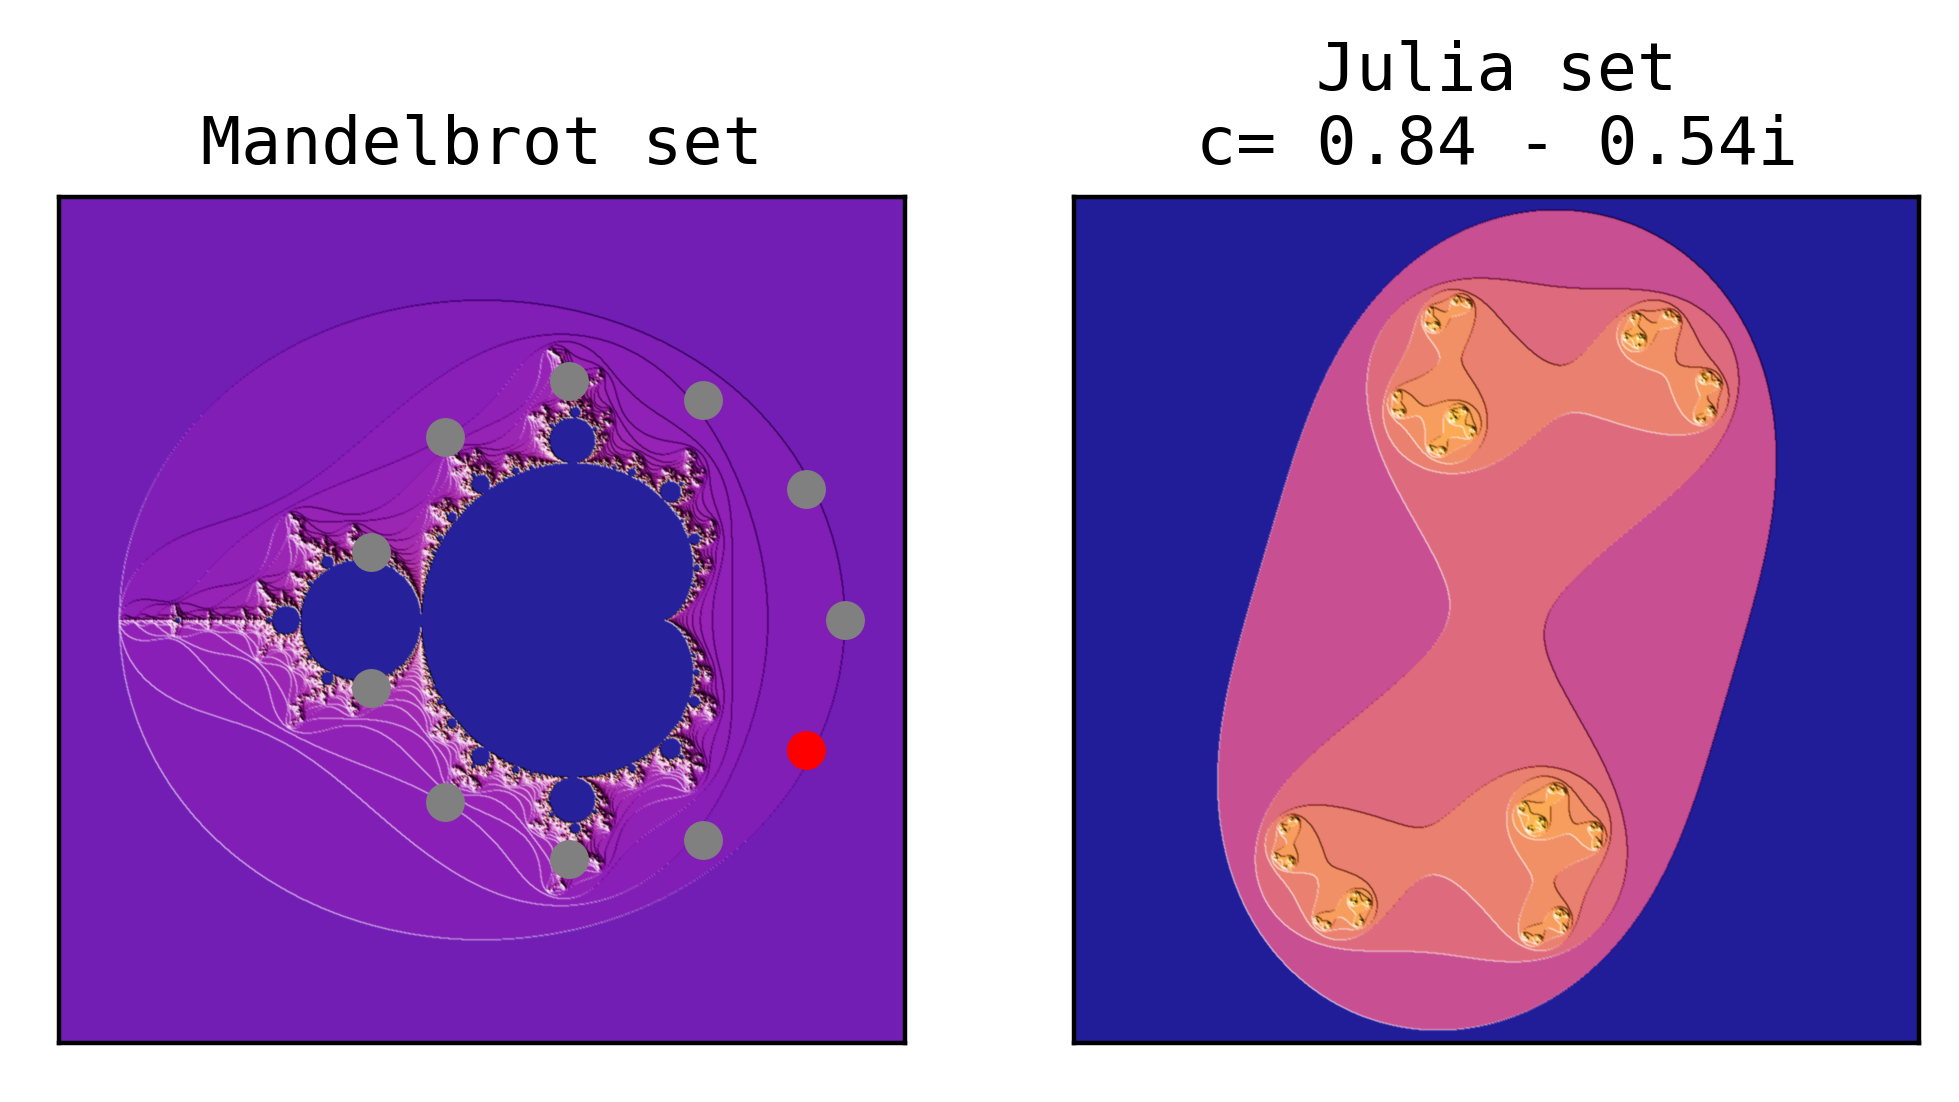

In [6]:
# This can be done locally with the outfiles from redhawk
!rm -rf frames/*.png

# make_gif(
#  xc, yc, npts, radius, verbose=False, gifname="frames/fractal.gif", outdir="outfiles/"
# )
make_gif(0, 0, 11, 1, verbose=True)

<a id='gif'></a>
#### Final GIF!

![](frames/fractal.gif)

[back to top](#toc)